<a href="https://colab.research.google.com/github/rfausas/QLswimmers/blob/master/QLAnalis_roberto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import copy
import matplotlib.pylab as plt
import scipy.signal


In [ ]:
#experiencias geradas com codigo Swimmer_analise.py
case = 1

if case == 1:
  !wget https://github.com/rfausas/QLswimmers/raw/master/Estudo_Swimmer/evolqlquantities.txt -O evolqlquantities.txt &> /dev/null
    

In [1]:
tbtp = 'f'
tbcase = 9

if tbtp == 'f':
      if tbcase == 1:
          !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASfino/theta5/deltas.txt -O deltas.txt &> /dev/null
      elif tbcase == 2:
          !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASfino/theta10/deltas.txt -O deltas.txt &> /dev/null 
      elif tbcase == 3:
          !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASfino/theta15/deltas.txt -O deltas.txt &> /dev/null
      elif tbcase == 4:
          !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASfino/theta20/deltas.txt -O deltas.txt &> /dev/null
      elif tbcase == 5:
          !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASfino/theta25/deltas.txt -O deltas.txt &> /dev/null
      elif tbcase == 6:
          !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASfino/theta30/deltas.txt -O deltas.txt &> /dev/null
      elif tbcase == 7:
          !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASfino/theta35/deltas.txt -O deltas.txt &> /dev/null
      elif tbcase == 8:
          !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASfino/theta40/deltas.txt -O deltas.txt &> /dev/null
      elif tbcase == 9:
          !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASfino/theta45/deltas.txt -O deltas.txt &> /dev/null                               
elif tbtp == 'i':  
    if tbcase == 1:
        !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASgrosso/theta5/deltas.txt -O deltas.txt &> /dev/null
    elif tbcase == 2:
        !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASgrosso/theta10/deltas.txt -O deltas.txt &> /dev/null 
    elif tbcase == 3:
        !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASgrosso/theta15/deltas.txt -O deltas.txt &> /dev/null
    elif tbcase == 4:
        !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASgrosso/theta20/deltas.txt -O deltas.txt &> /dev/null
    elif tbcase == 5:
        !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASgrosso/theta25/deltas.txt -O deltas.txt &> /dev/null
    elif tbcase == 6:
        !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASgrosso/theta30/deltas.txt -O deltas.txt &> /dev/null
    elif tbcase == 7:
        !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASgrosso/theta35/deltas.txt -O deltas.txt &> /dev/null
    elif tbcase == 8:
        !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASgrosso/theta40/deltas.txt -O deltas.txt &> /dev/null
    elif tbcase == 9:
        !wget https://raw.githubusercontent.com/lucianodellier/Estudo_Swimmer/main/DELTAS/DELTASgrosso/theta45/deltas.txt -O deltas.txt &> /dev/null 

In [3]:
dir_   = '.'
eqlfile = 'evolqlquantities.txt'
EQL = np.loadtxt(dir_+'/'+eqlfile, delimiter=',', skiprows=1)

deltasfile = 'DELTAS/DELTASfino/theta45/deltas.txt'
DELTAS = np.loadtxt(dir_+'/'+deltasfile)

print(EQL.shape, len(DELTAS))


(10000, 9) 48


In [9]:
nballs = 4
nlinks = nballs-1
nstates = 2**nlinks
nactions = nlinks
ndeltas = 6

tfdata = len(EQL) 
nqlsteps = tfdata

# Here, the letter "n" in the name of a variable, means "next"

s_batch  = np.asarray(EQL[:tfdata,0],dtype=np.int32)
a_batch  = np.asarray(EQL[:tfdata,1],dtype=np.int32)
sn_batch = np.asarray(EQL[:tfdata,2],dtype=np.int32)
x_batch  = np.asarray(EQL[:tfdata,3],dtype=np.int32)
y_batch  = np.asarray(EQL[:tfdata,4],dtype=np.int32)
xn_batch = np.asarray(EQL[:tfdata,5],dtype=np.int32)
yn_batch = np.asarray(EQL[:tfdata,6],dtype=np.int32)
theta_batch  = np.asarray(EQL[:tfdata,7],dtype=np.int32)
thetan_batch = np.asarray(EQL[:tfdata,8],dtype=np.int32)

Lx, Ly = 3 * 150.0, 3 * 150.0
xc_ini, yc_ini = Lx/2.0, Ly/2.0

rcase = 4

if (rcase == 1): #rotation
    r_batch = EQL[:tfdata,8] - EQL[:tfdata,7]
elif (rcase == 2): #translation
    r_batch = xn_batch - x_batch 
elif (rcase == 3): #escape from initial point
    distn = np.sqrt((xn_batch - xc_ini)**2 + (yn_batch - yc_ini)**2)
    dist = np.sqrt((x_batch - xc_ini)**2 + (y_batch - yc_ini)**2)
    r_batch = distn - dist
elif (rcase == 4):
    deltax = xn_batch - x_batch
    deltay = yn_batch - y_batch
    #thetaup = 1.5*np.pi
    #thetalo = 0.5*np.pi
    thetalo = 0.5*np.pi
    thetaup = np.pi
    angle = np.arctan2(deltay,deltax)
    r_batch = -1.0*np.ones(tfdata)
    #r_batch[np.where(angle > thetalo and angle < thetaup)] = 1.0
    for it in range(tfdata):
      if(angle[it] < 0):
        angle[it] += 2.0*np.pi
      if(angle[it] > thetalo and angle[it] < thetaup):
        r_batch[it] = 1.0
    


In [10]:
from Swimmer_Analise_angle import ComputeAngleStateBody, Nangs

def QL_steps_sb(s_batch,sn_batch,a_batch,r_batch,alpha,gamma,replay_step,nreplay):
  # Initilize QL matrix

  nstates_glob = (2 ** nlinks) * Nangs
  MQL  = np.zeros((nstates_glob,nactions))
  MQLn = np.zeros((nstates_glob,nactions))
  DMQL = []
  RDMQL = []

  # QL steps
  for it in range(nqlsteps):   
    
    # Learning  #######################################################    
    prev_state_dec          = s_batch[it]
    next_action_dec         = a_batch[it]
    next_state_dec          = sn_batch[it]
    next_MQLmax             = np.max(MQL[next_state_dec,:])
    next_MQLmax_inverse     = np.max(MQL[prev_state_dec,:])
    current_MQLval          = MQL[prev_state_dec,next_action_dec]
    current_MQLval_inverse  = MQL[prev_state_dec,next_action_dec]
    current_reward          = r_batch[it]    

    MQL[prev_state_dec,next_action_dec] = (1-alpha)*current_MQLval + \
      alpha*(current_reward + gamma*next_MQLmax)

    MQL[next_state_dec,next_action_dec] = (1-alpha)*current_MQLval_inverse + \
      alpha*(-current_reward + gamma*next_MQLmax_inverse)   

    if replay_step > 0 and it%replay_step == 0:
      MQL, DMQL = replay_sb(MQL,s_batch,sn_batch,a_batch,r_batch,alpha,gamma,nreplay,DMQL)
      #MQL, DMQL = replay_sb(MQL,s_batch[it-nbatch:it],sn_batch[it-nbatch:it],a_batch[it-nbatch:it],r_batch[it-nbatch:it],alpha,gamma,nreplay,DMQL)

    DMQL.append(np.linalg.norm(MQL-MQLn))
    RDMQL.append(np.linalg.norm(MQL-MQLn)/(np.linalg.norm(MQL)+1.0e-10))
    MQLn = copy.deepcopy(MQL)    

  return MQL, DMQL


def replay_sb(MQL,s_batch,sn_batch,a_batch,r_batch,alpha,gamma,nreplay,DMQL):
 
   MQLC = copy.deepcopy(MQL)
   MQLn = copy.deepcopy(MQL)

   for i in range(nreplay):     
      rl = np.random.randint(s_batch.shape[0], size=1)[0]
      prev_state_dec    = s_batch[rl]
      next_action_dec   = a_batch[rl]
      next_state_dec    = sn_batch[rl]
      next_MQLmax       = np.max(MQLC[next_state_dec,:])
      next_MQLmax_inv   = np.max(MQL[prev_state_dec,:])
      current_MQLval    = MQLC[prev_state_dec,next_action_dec]
      current_MQLval_inv= MQLC[prev_state_dec,next_action_dec]
      current_reward    = r_batch[rl]
      
      MQLC[prev_state_dec,next_action_dec] = (1-alpha)*current_MQLval + \
         alpha*(current_reward + gamma*next_MQLmax)

      MQLC[next_state_dec,next_action_dec] = (1-alpha)*current_MQLval_inv + \
         alpha*(-current_reward + gamma*next_MQLmax_inv)
         
      DMQL.append(DMQL.append(np.linalg.norm(MQLC-MQLn)/np.linalg.norm(MQLC-MQLn))) #np.max(MQLC-MQLn)
      MQLn = copy.deepcopy(MQLC)
   
   return MQLC, DMQL  

def ReadDeltasTables(ndeltas, nstates, nactions, filetable):            
    
    A = filetable
    Deltas = []
    for d in range(ndeltas):
        Deltas.append(np.zeros(shape=(nstates, nactions)))
        for state in range(nstates):
            Deltas[d][state, :] = A[d * nstates + state, :]
    return Deltas 

def find_gait_sb(state_dec, theta_ini, MQL):
  vel = 0.0
  slist_int = []
  slist = []
  alist = []
  xlist = [xc_ini]
  ylist = [yc_ini]
  thetalist = [theta_ini]
  current_state_dec = state_dec
  Deltas = ReadDeltasTables(ndeltas, nstates, nactions, DELTAS)
  current_disp = np.zeros(2)
  k = 0
  vel1 = vel2 = 0
  aux = np.zeros(2)
                 
  for j in range(1000):
    
    action = np.zeros(nlinks, dtype=int)
                 
    aux_current = np.array([int(i) for i in np.binary_repr(current_state_dec,width=nlinks)])
    
    current_angle_state, current_itheta  = ComputeAngleStateBody(thetalist[j], aux_current, 1)
    
    current_state_dec_glob = current_state_dec  + current_itheta  * nstates
    
    action[np.argmax(MQL[current_state_dec_glob,:])] = 1
                     
    action_dec = np.argmax(MQL[current_state_dec_glob,:])
    
    aux_state = np.remainder(aux_current+action,2*np.ones(nlinks, dtype=int))    
        
    next_state_dec = np.dot(aux_state,2**np.arange(nlinks-1,-1,-1,dtype=int))    
    
    if(j>99):
      if (rcase == 1):
        vel1 += (Deltas[2][current_state_dec, action.argmax()] - Deltas[2][next_state_dec, action.argmax()])/2
      elif (rcase == 2 or rcase == 3 or rcase == 4):
        Rmatrix = np.array([
                            [np.cos(thetalist[j]), -np.sin(thetalist[j])],
                            [np.sin(thetalist[j]),  np.cos(thetalist[j])],
                           ])
        current_disp[0] = Deltas[0][current_state_dec, action.argmax()]
        current_disp[1] = Deltas[1][current_state_dec, action.argmax()]
        aux = Rmatrix @ current_disp
        if(j > 900):
          vel1 += aux[0]
          vel2 += aux[1]

    xlist.append(xlist[j] + aux[0])
    ylist.append(ylist[j] + aux[1])
    thetalist.append(thetalist[j] + Deltas[2][current_state_dec, action.argmax()])
    
    slist.append(current_state_dec_glob)
    slist_int.append(current_state_dec)
    alist.append(action_dec)
    
    current_state_dec = next_state_dec 
  
  vel1 = vel1/100
  vel2 = vel2/100
  return slist[990:1000], alist[990:1000], vel1, vel2, xlist[900:1000], ylist[900:1000], thetalist[900:1000]
 
  

In [13]:
gammalist = [0.999, 0.9]
alphalist = [1.0, 0.8]

nreplay = 100
replay_step = 0

for alpha in alphalist:
  for gamma in gammalist:
    MQL, DMQL = QL_steps_sb(s_batch,sn_batch,a_batch,r_batch,alpha,gamma,replay_step,nreplay)

    theta_ini = theta_batch[-1]
    prev_state_dec_glob  = s_batch[-1]
    prev_angle_state, prev_itheta  = ComputeAngleStateBody(theta_ini, , 1)
    
    prev_state_dec = prev_state_dec_glob  - prev_itheta  * nstates
    
    slist, alist, vel1, vel2, xlist, ylist, thetalist = find_gait_sb(prev_state_dec, theta_ini, MQL)
    FDMQL = scipy.signal.savgol_filter(DMQL,15,0)    
    print(f'alpha = {alpha}, gamma = {gamma:.3f}, dQ = {FDMQL[-1]:e}, {slist}, {alist}, vel1 = {vel1:.5f}, vel2 = {vel2:.5f}, velmod = {np.sqrt(vel1**2+vel2**2):.5f}')    
 
    

NameError: name 'aux_current' is not defined

alpha = 1.0, gamma = 0.500, dQ = 2.469975e+00, [0, 2, 6, 4, 0, 2, 6, 4, 0, 2], [1, 0, 1, 0, 1, 0, 1, 0, 1, 0], vel1 = -0.05303, vel2 = 0.02548, velmod = 0.05884


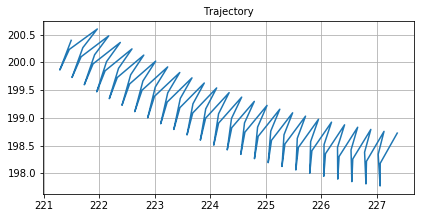

In [9]:
alpha = 1.0
gamma = 0.9

MQL, DMQL = QL_steps_sb(s_batch,sn_batch,a_batch,r_batch,alpha,gamma,replay_step,nreplay)
prev_state_dec  = s_batch[-1]
slist, alist, vel1, vel2, xlist, ylist, thetalist = find_gait_sb(prev_state_dec, MQL)
FDMQL = scipy.signal.savgol_filter(DMQL,15,0)    
print(f'alpha = {alpha}, gamma = {gamma:.3f}, dQ = {FDMQL[-1]:e}, {slist}, {alist}, vel1 = {vel1:.5f}, vel2 = {vel2:.5f}, velmod = {np.sqrt(vel1**2+vel2**2):.5f}')   

fig, axs = plt.subplots(1, 1)
axs.plot(xlist, ylist)
axs.set_aspect('equal', 'box')
axs.grid()
#axs.set(xlim=(210, 240), ylim=(210, 240))
axs.set_title('Trajectory', fontsize=10)
fig.tight_layout()
plt.show()

alpha = 0.4, gamma = 0.500, dQ = 1.058697e+00, [6, 4, 5, 1, 0, 2, 6, 4, 5, 1], [1, 2, 0, 2, 1, 0, 1, 2, 0, 2], vel1 = -0.00666, vel2 = -0.00447, velmod = 0.00802


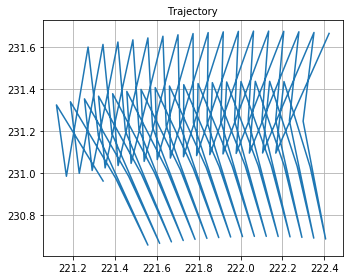

In [10]:
alpha = 0.4
gamma = 0.5

MQL, DMQL = QL_steps_sb(s_batch,sn_batch,a_batch,r_batch,alpha,gamma,replay_step,nreplay)
prev_state_dec  = s_batch[-1]
slist, alist, vel1, vel2, xlist, ylist, thetalist = find_gait_sb(prev_state_dec, MQL)
FDMQL = scipy.signal.savgol_filter(DMQL,15,0)    
print(f'alpha = {alpha}, gamma = {gamma:.3f}, dQ = {FDMQL[-1]:e}, {slist}, {alist}, vel1 = {vel1:.5f}, vel2 = {vel2:.5f}, velmod = {np.sqrt(vel1**2+vel2**2):.5f}')   

fig, axs = plt.subplots(1, 1)
axs.plot(xlist[90:-1], ylist[90:-1])
axs.set_aspect('equal', 'box')
axs.grid()
#axs.set(xlim=(210, 240), ylim=(210, 240))
axs.set_title('Trajectory', fontsize=10)
fig.tight_layout()
plt.show()

[221.25619521649017, 221.46706074175236, 221.61445718116724, 221.38662318130474, 221.34438533940843, 221.23135941390527, 221.18930690486354, 221.40598477331196, 221.5584058591268, 221.32231407347706, 221.27338650791572, 221.17007798483448, 221.12264673187863] [231.35463627778768, 230.98502323299323, 230.6657762673438, 231.190330853984, 231.6141540668715, 230.9998915783734, 231.3407224152391, 230.97448646130914, 230.65760770211634, 231.17849781971054, 231.6016009329094, 230.98562965624913, 231.32575367645106]


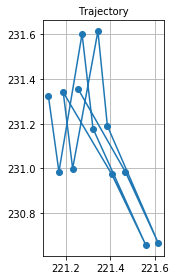

In [18]:
fig, axs = plt.subplots(1, 1)
axs.plot(xlist[86:-1], ylist[86:-1], '-o')
print(xlist[86:-1], ylist[86:-1])
axs.set_aspect('equal', 'box')
axs.grid()
#axs.set(xlim=(210, 240), ylim=(210, 240))
axs.set_title('Trajectory', fontsize=10)
fig.tight_layout()
plt.show()

In [5]:
import numpy as np
A=[5,2,1,4,7,8,1,5,5,2,1,4,7,8,1,5,5,2,1,4,7,8,1,5,5,2,1,4,7,8,1,5]
S=dict()
L=7+1
for i in range(len(A)-L+1):
    key=tuple(A[i:i+L])
    if key in S:
        print (S[key])
    else:
        S[key] = i
print(S)

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
{(5, 2, 1, 4, 7, 8): 0, (2, 1, 4, 7, 8, 1): 1, (1, 4, 7, 8, 1, 5): 2, (4, 7, 8, 1, 5, 5): 3, (7, 8, 1, 5, 5, 2): 4, (8, 1, 5, 5, 2, 1): 5, (1, 5, 5, 2, 1, 4): 6, (5, 5, 2, 1, 4, 7): 7}
